# Polyphase Filter Bank with Sine Functions

This example shows the result of standard polyphase filter banks on channelizing a set of sine signal.

In [2]:
from pathlib import Path
import numpy as np
import scipy.signal as sig
from mitarspysigproc import (
    pfb_decompose,
    pfb_reconstruct,
    kaiser_coeffs,
    kaiser_syn_coeffs,
)
import matplotlib.pyplot as plt

In [3]:
def create_sin(t_len, fs, bw, nchans, pad):
    """Creates a signal with multiple cosines

    Parameters
    ----------
    t_len : float
        Length of chirp in seconds
    fs : float
        Sampling frequency in Hz
    bw : float
        Bandwidth of chirp
    nzeros : tuple
        Number of zeros to pad in the begining and end of the array.
    nchans : int
        Number of channels for the PFB
    nslice : int
        Number of time samples from the pfb

    Returns
    -------
    tout : ndarray
        The time vector for the created signal
    xout : ndarray
        Created signal
    """

    s_list = np.arange(int(nchans * bw / fs))

    t = np.linspace(0, t_len, t_len * fs)
    flist = [np.cos(2 * np.pi * (i / nchans) * fs * t) for i in s_list]
    x = sum(flist)

    xout = np.concatenate((pad[0], x, pad[1]), axis=0)
    tp1 = -1 * np.arange(0, len(pad[0]), dtype=float)[::-1] / fs
    tp2 = np.arange(0, len(pad[1]), dtype=float) / fs + t_len
    tout = np.concatenate((tp1, t, tp2), axis=0)

    return tout, xout


def runsintest(t_len, fs, bw, nzeros, nchans):
    """Creates a superposition of sin waves  and runs the standard PFB analysis and reconstruction

    Parameters
    ----------
    t_len : float
        Length of chirp in seconds
    fs : float
        Sampling frequency in Hz
    bw : float
        Bandwidth of chirp
    nzeros : int
        Number of zeros to pad
    nchans : int
        Number of channels for the PFB

    Returns
    -------
    x_rec : ndarray
        Reconstructed signal
    tin : ndarray
        The time vector for the input signal
    x : ndarray
        Input signal
    x_pfb : ndarray
        The ouptut data
    """
    pad = [np.zeros(nzeros), np.zeros(nzeros)]
    t, x = create_sin(t_len, fs, bw, nchans, pad)
    coeffs = kaiser_coeffs(nchans, pow2=False)
    mask = np.ones(nchans, dtype=bool)
    xout = pfb_decompose(x, nchans, coeffs, mask)
    fillmethod = ""
    fillparams = [0, 0]
    syn_coeffs = kaiser_syn_coeffs(nchans, pow2=False)
    x_rec = pfb_reconstruct(
        xout, nchans, syn_coeffs, mask, fillmethod, fillparams=[], realout=True
    )
    return x_rec, t, x, xout


def nexpow2(x):
    """Returns the next power of two.

    Parameters
    ----------
    x : int
        Inital number.

    Returns
    -------
    int
        The next power of two of x.
    """

    return int(np.power(2, np.ceil(np.log2(x))))


def plotdata(inchirp, outchirp, tin, tout,g_del=0):
    """Plot the data and return the figure.

    Parameters
    ----------
    x : ndarray
        Input signal
    x_rec : ndarray
        Reconstructed signal
    tin : ndarray
        The time vector for the input signal
    tout : ndarray
        The time vector for the output signal

    Returns
    -------
    fig : matplotlib.fig
        The matplotlib fig for plotting or saving.

    """

    fig, ax = plt.subplots(2, 1, figsize=(10, 5))

    inlen = inchirp.shape[0]
    outlen = outchirp.shape[0]
    tau = tin[1] - tin[0]

    ax[0].plot(tin, inchirp, label="Input")
    ax[0].plot(tout, np.roll(outchirp,-g_del), label="Output")

    ax[0].set_xlabel("Time in Seconds")
    ax[0].set_ylabel("Amplitude")
    ax[0].set_title("Time Domain")
    ax[0].grid(True)

    nfft_in = nexpow2(inlen)
    nfft_out = nexpow2(outlen)

    in_freq = np.fft.fftshift(np.fft.fftfreq(nfft_in, d=tau))
    out_freq = np.fft.fftshift(np.fft.fftfreq(nfft_out, d=tau))

    spec_in = np.abs(np.fft.fftshift(np.fft.fft(inchirp, n=nfft_in))) ** 2
    spec_out = np.abs(np.fft.fftshift(np.fft.fft(outchirp[:, 0], n=nfft_out))) ** 2

    spec_in_log = 10 * np.log10(spec_in)
    spec_out_log = 10 * np.log10(spec_out)

    ax[1].plot(in_freq, spec_in_log, label="Input")
    ax[1].plot(out_freq, spec_out_log, label="Output")

    ax[1].set_xlabel("Frequency in Hz")
    ax[1].set_ylabel("Amp dB")
    ax[1].set_title("Frequency Content")
    ax[1].grid(True)
    ax[1].set_ylim([0, 90])

    fig.tight_layout()
    return fig


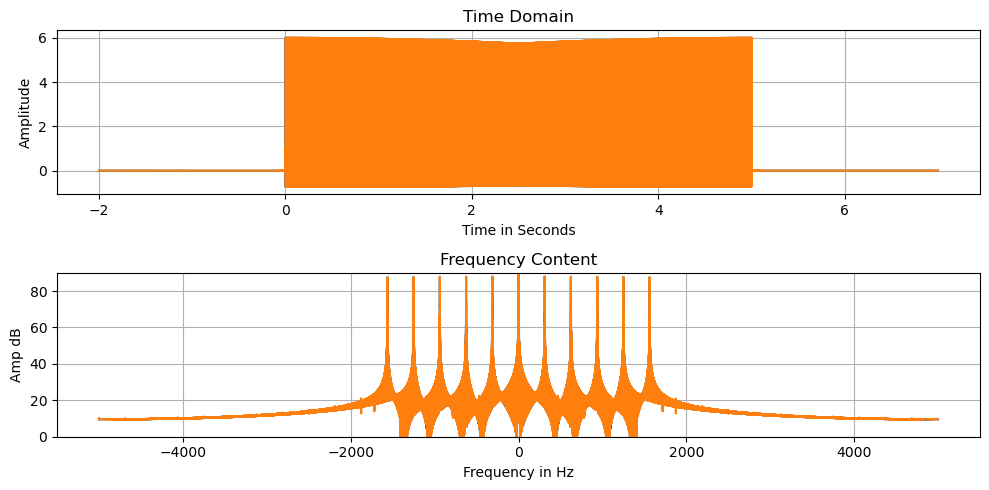

In [4]:
t_len = 5
fs = 10000
bw = 2000
nzeros = 20000
nchans = 32

x_rec, t, x, _ = runsintest(t_len, fs, bw, nzeros, nchans)
x_rec = x_rec[: len(x)]

g_del = nchans * (64 - 1) // 2
fig = plotdata(x, x_rec, t, t,2*g_del)